# Trajectories of the electrification of vehicles in the world

In this notebook, I try to look for an overarching pattern in the electrification of the worlds vehicle sales.

### Imports and various tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import correlate_slice_normalized, df_shift_index

%load_ext autoreload
%autoreload 2

from owid_datagrabber import owid_electric_car_sales

In [2]:
# Test the OWID catalog
#from owid import catalog
#catalog.find('6376')

OWID somehow doesn't provide the full dataset for electric car sales through their API, but following some links in the API, the raw download can be found (which is actually a google sheet)
and this csv is now used in this calculation

In [3]:
e_car_sales = owid_electric_car_sales()
e_car_sales

ev_sales_share  ev_stock_share   bev_sales   bev_stock  \
Entity    year                                                           
Australia 2011          0.0061         0.00039        49.0        49.0   
          2012          0.0290         0.00240       170.0       220.0   
          2013          0.0330         0.00460       190.0       410.0   
          2014          0.1500         0.01400       370.0       780.0   
          2015          0.1900         0.02700       760.0      1500.0   
...                        ...             ...         ...         ...   
World     2020          4.4000         0.86000   2000000.0   6800000.0   
          2021          9.3000         1.40000   4700000.0  11000000.0   
          2022         15.0000         2.10000   7300000.0  18000000.0   
          2023         18.0000         3.20000   9500000.0  28000000.0   
          2024         22.0000         4.50000  11000000.0  39000000.0   

                phev_sales  phev_stock    ev_sales  bev_share_ev_cars  \
Entity    year                                                          
Australia 2011         NaN         NaN         NaN                NaN   
          2012        80.0        80.0       250.0          68.000000   
          2013       100.0       180.0       290.0          65.517241   
          2014       950.0      1100.0      1320.0          28.030303   
          2015      1000.0      2100.0      1760.0          43.181818   
...                    ...         ...         ...                ...   
World     2020    970000.0   3400000.0   2970000.0          67.340067   
          2021   1900000.0   5300000.0   6600000.0          71.212121   
          2022   2900000.0   8000000.0  10200000.0          71.568628   
          2023   4200000.0  12000000.0  13700000.0          69.343066   
          2024   6500000.0  19000000.0  17500000.0          62.857143   

                phev_share_ev_cars  bev_share_car_sales  phev_share_car_sales  \
Entity    year                                                                  
Australia 2011                 NaN                  NaN                   NaN   
          2012           32.000000             0.019720              0.009280   
          2013           34.482759             0.021621              0.011379   
          2014           71.969697             0.042045              0.107955   
          2015           56.818182             0.082045              0.107955   
...                            ...                  ...                   ...   
World     2020           32.659933             2.962963              1.437037   
          2021           28.787879             6.622727              2.677273   
          2022           28.431372            10.735294              4.264706   
          2023           30.656934            12.481752              5.518248   
          2024           37.142857            13.828571              8.171429   

                  ev_stock  total_cars_sold  non_ev_cars_sold  
Entity    year                                                 
Australia 2011         NaN              NaN               NaN  
          2012       300.0         862069.0          861819.0  
          2013       590.0         878788.0          878498.0  
          2014      1880.0         880000.0          878680.0  
          2015      3600.0         926316.0          924556.0  
...                    ...              ...               ...  
World     2020  10200000.0       67500000.0        64530000.0  
          2021  16300000.0       70967742.0        64367742.0  
          2022  26000000.0       68000000.0        57800000.0  
          2023  40000000.0       76111111.0        62411111.0  
          2024  58000000.0       79545455.0        62045455.0  

[499 rows x 14 columns]

In [4]:
# Test e_car_sales
# e_car_sales
e_car_sales.loc[('Germany', 2024), 'ev_sales_share']

# Examples (concise):
from IPython.display import display

# yearly data for specific country
#display(e_car_sales.loc['Germany'])

# all countries 2023 data
#display(e_car_sales.xs(2023, level=1))

# ev_sales_share for all countries in 2023
e_car_sales['ev_sales_share'].xs(2023, level=1)


Entity
Australia              12.00
Austria                27.00
Belgium                41.00
Brazil                  3.00
Canada                 13.00
Chile                   0.75
China                  38.00
Denmark                46.00
European Union (27)    22.00
Europe                 22.00
Finland                54.00
France                 25.00
Germany                24.00
Greece                 13.00
Iceland                71.00
India                   2.10
Israel                 17.00
Italy                   9.20
Japan                   3.50
South Korea             8.70
Mexico                  1.50
Netherlands            44.00
New Zealand            27.00
Norway                 90.00
Poland                  6.40
Portugal               32.00
Rest of World           2.70
Spain                  12.00
Sweden                 60.00
Switzerland            30.00
Turkey                  7.20
United States           9.50
United Kingdom         24.00
World                  18.00
Name: e

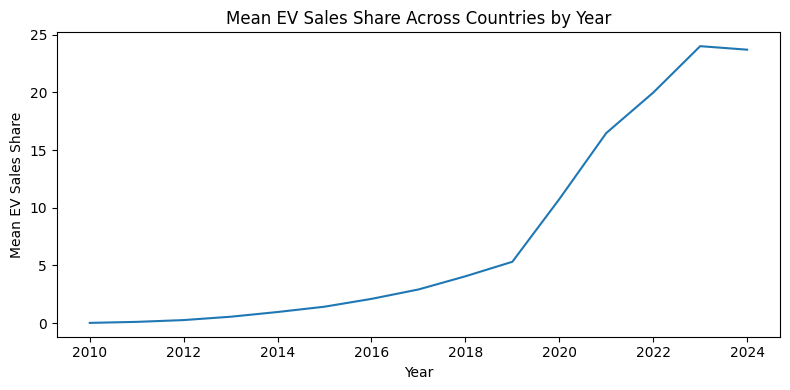

In [5]:
# Calculate mean ev_sales_share across countries for each year
ev_sales_share_mean = (
    e_car_sales['ev_sales_share']
    .groupby(level=1)
    .mean()
    .sort_index()
    .to_frame(name='mean_ev_sales_share')
)

# Display the aggregated data
ev_sales_share_mean

# Plot the yearly mean ev_sales_share
ax = ev_sales_share_mean.plot(figsize=(8, 4), legend=False)
ax.set_title('Mean EV Sales Share Across Countries by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mean EV Sales Share')
plt.tight_layout()
plt.show()


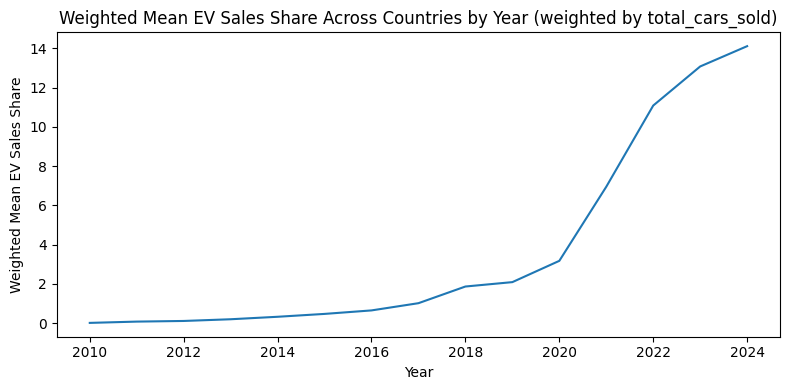

In [6]:
only_countries = np.invert(e_car_sales.index.get_level_values(0).isin(['World', 'European Union (27)', 'Europe']))

weighted_ev_sales_share_mean = (
        (e_car_sales[only_countries]['bev_share_car_sales'] * e_car_sales[only_countries]['total_cars_sold'])
        .groupby(level=1)
        .sum()
        /
        e_car_sales[only_countries]['total_cars_sold'].groupby(level=1).sum()
).sort_index().to_frame(name='weighted_mean_ev_sales_share')

weighted_ev_sales_share_mean

ax = weighted_ev_sales_share_mean.plot(figsize=(8, 4), legend=False)
ax.set_title('Weighted Mean EV Sales Share Across Countries by Year (weighted by total_cars_sold)')
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Mean EV Sales Share')
plt.tight_layout()
plt.show()

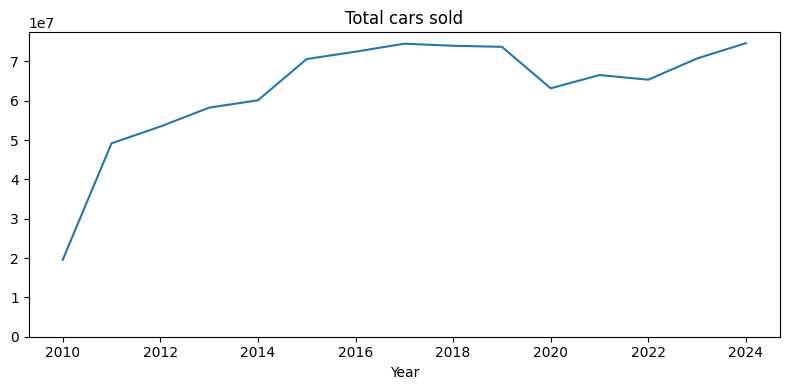

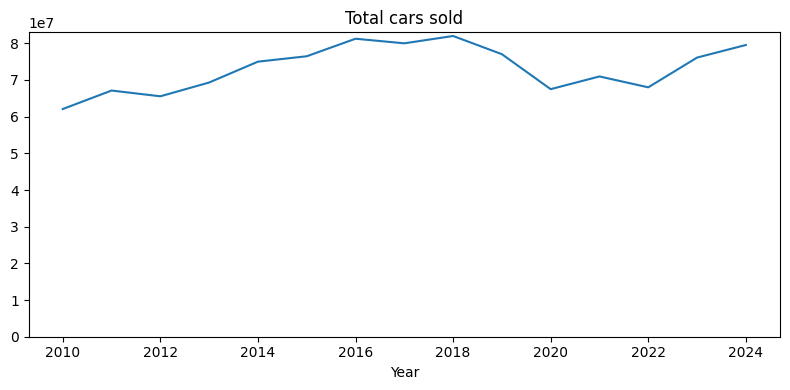

In [7]:


ax = e_car_sales[only_countries]['total_cars_sold'].groupby(level=1).sum().plot(figsize=(8, 4), legend=False)
ax.set_title('Total cars sold')
ax.set_xlabel('Year')
ax.set_ylim(0)
plt.tight_layout()
plt.show()



ax = e_car_sales.loc['World']['total_cars_sold'].plot(figsize=(8, 4), legend=False)
ax.set_title('Total cars sold')
ax.set_xlabel('Year')
ax.set_ylim(0)
plt.tight_layout()
plt.show()

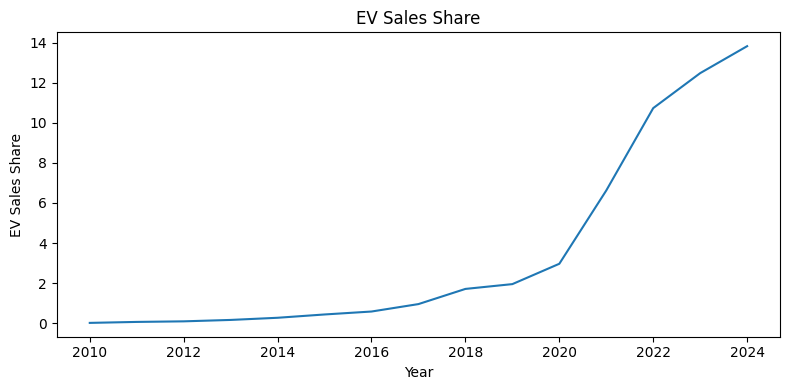

In [8]:


ax = e_car_sales.loc['World']['bev_share_car_sales'].plot(figsize=(8, 4), legend=False)
ax.set_title('EV Sales Share')
ax.set_xlabel('Year')
ax.set_ylabel('EV Sales Share')
plt.tight_layout()
plt.show()

## Correlating the EV sales fractions of all countries

The assumption behind this analysis is that all countries follow a similar pattern in their electrification of the vehicle sales,
some are just earlier than others.

This means that we can calculate a time-shift for every country on how much it is ahead / behind compared to the average transition to EVs.

To do this, the average fraction trajectory is calculated for both EVs (BEV + PHEV) and BEVs only and then for each individual country, the correlation to this average trajectory is calculated.  
From this, we can get the time shift of this country to the average transition.  
Now we can repeat this process of calculating the average trajectory of the now time-shifted countries' data and then re-assess the best correlation for every country.  
After a few iteration, this process somewhat converges to the result that can be seen below.

These plots can give a feeling for the speed of the transition and what to expect in the coming years.

Time shift of all the countries (how many years they are ahead / behind the average transition)


{'Australia': -1,
 'Austria': 1,
 'Belgium': 2,
 'Brazil': -4,
 'Canada': -1,
 'Chile': -6,
 'China': 2,
 'Denmark': 3,
 'Finland': 3,
 'France': 1,
 'Germany': 1,
 'Greece': -2,
 'Iceland': 5,
 'India': -5,
 'Israel': 0,
 'Italy': -2,
 'Japan': -5,
 'South Korea': -1,
 'Mexico': -6,
 'Netherlands': 3,
 'New Zealand': 1,
 'Norway': 8,
 'Poland': -3,
 'Portugal': 1,
 'Rest of World': -5,
 'Spain': -2,
 'Sweden': 3,
 'Switzerland': 1,
 'Turkey': -2,
 'United States': -2,
 'United Kingdom': 1}

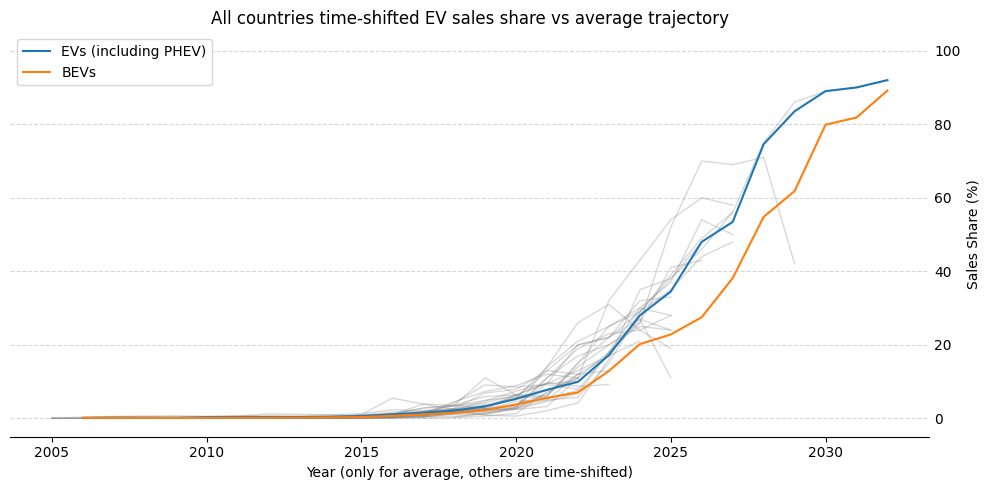

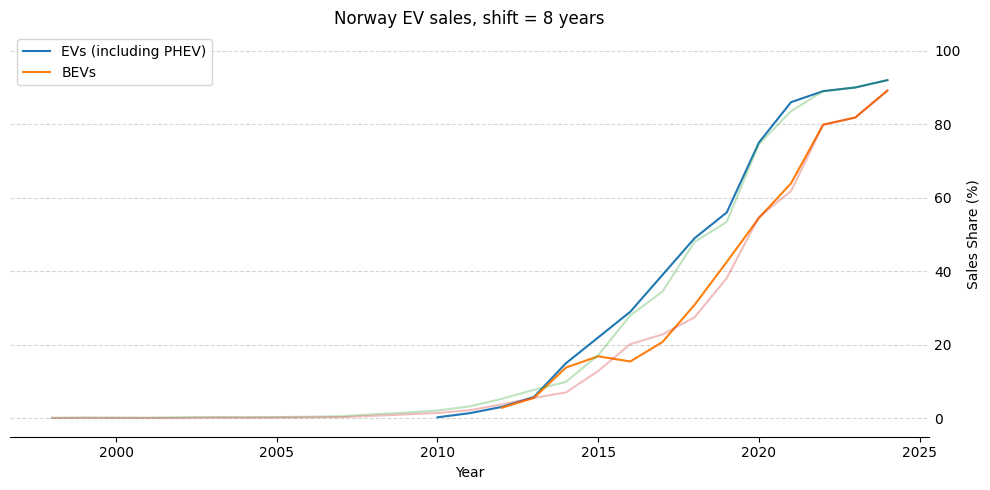

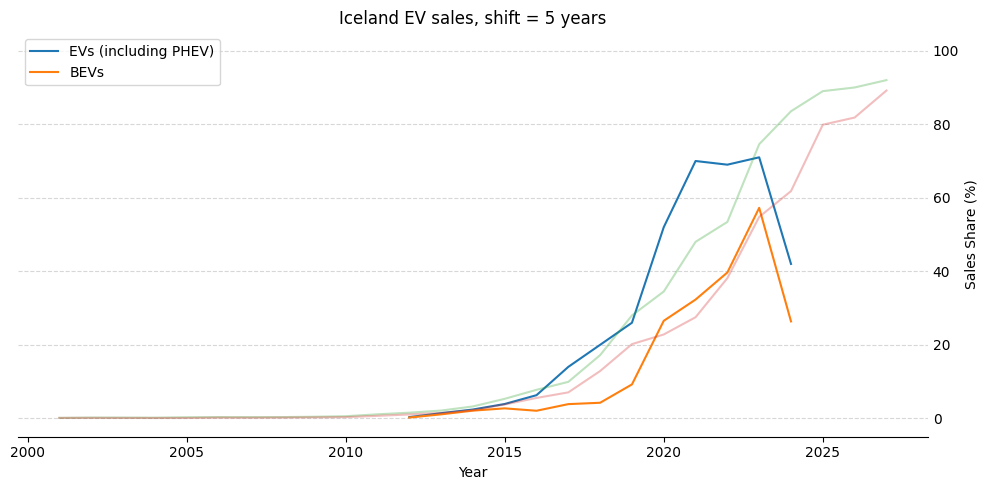

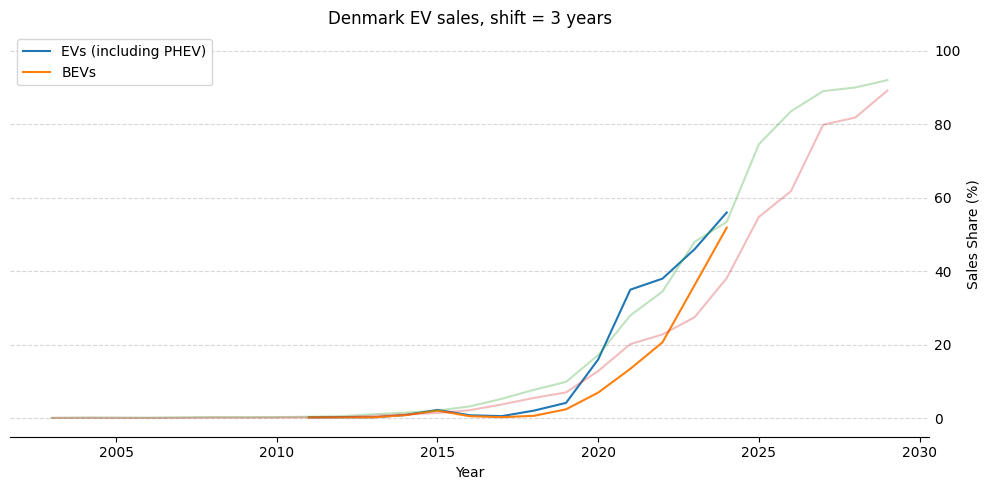

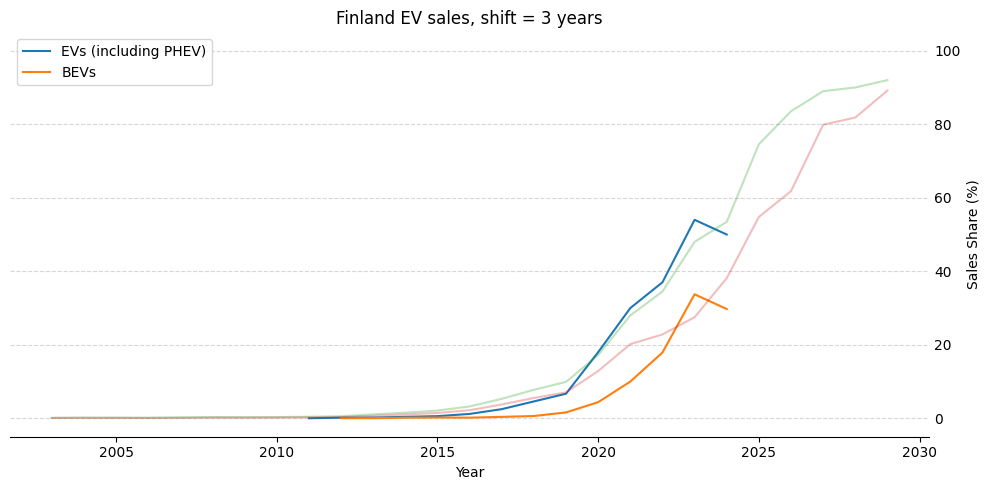

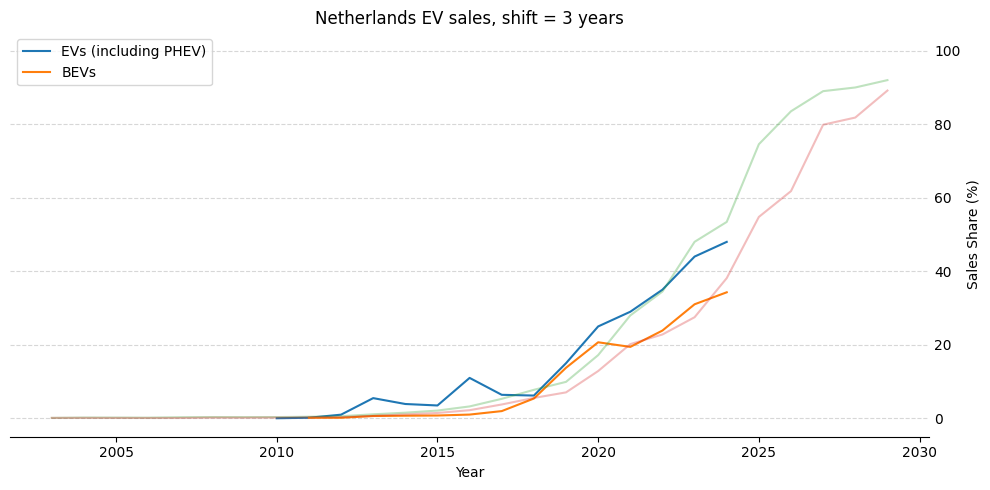

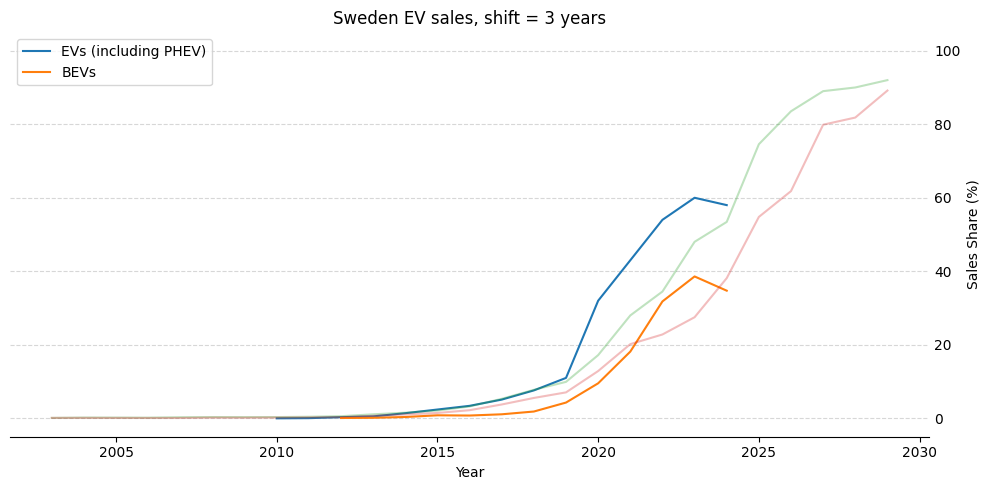

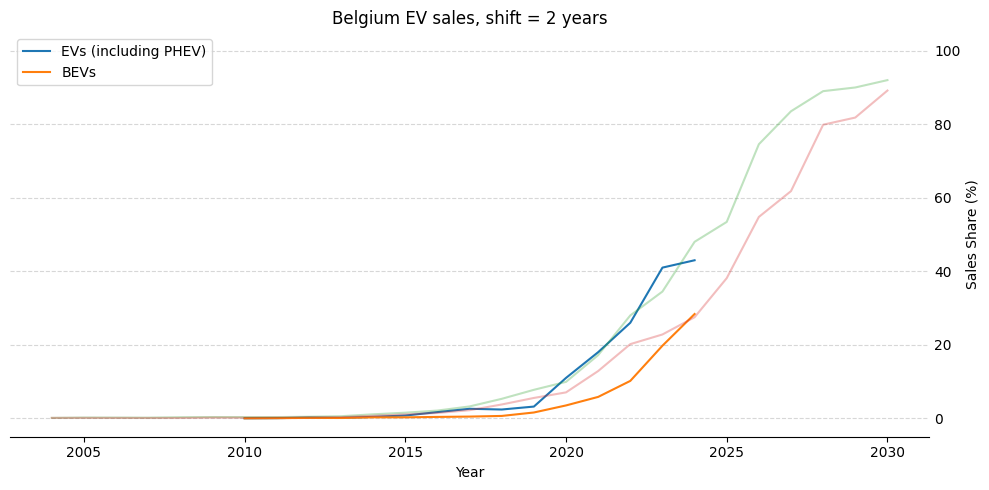

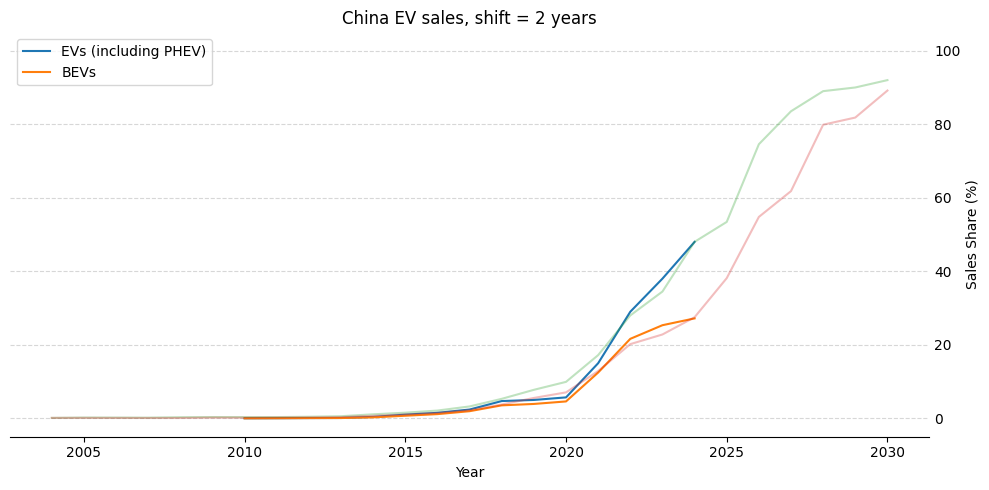

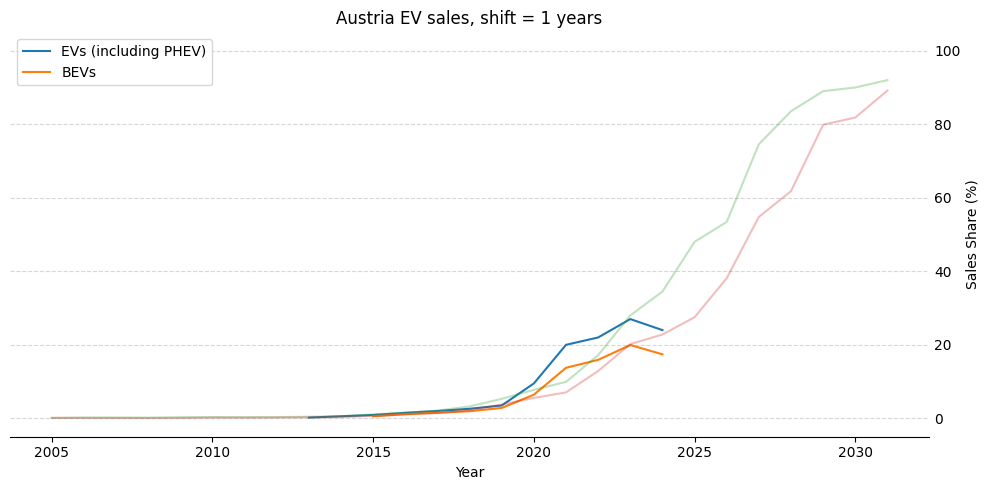

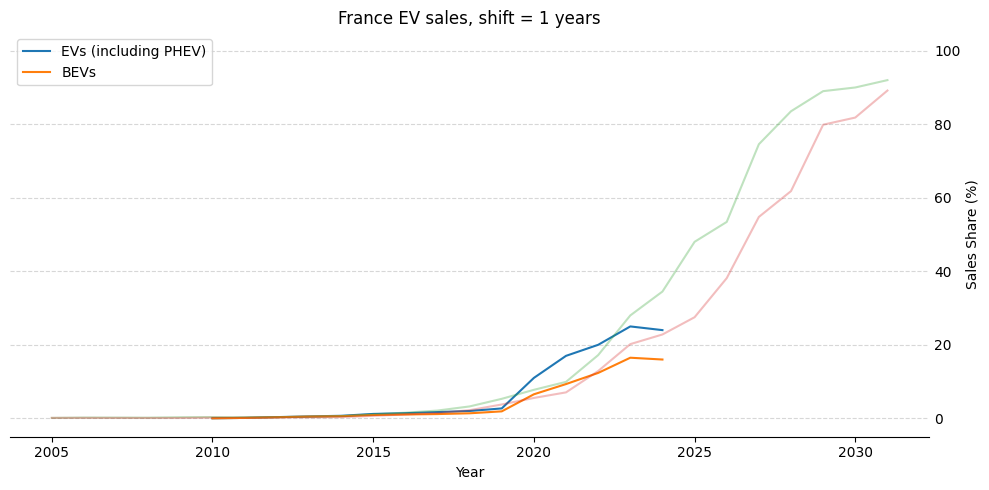

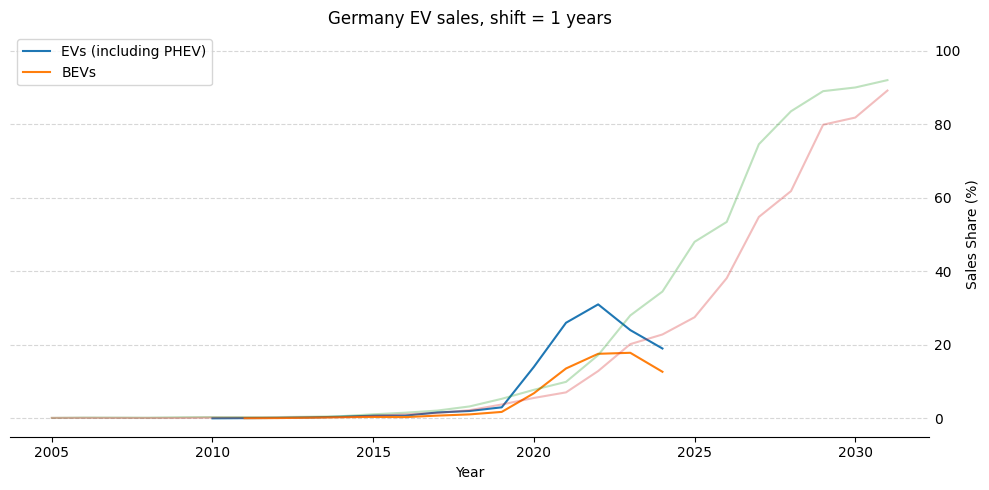

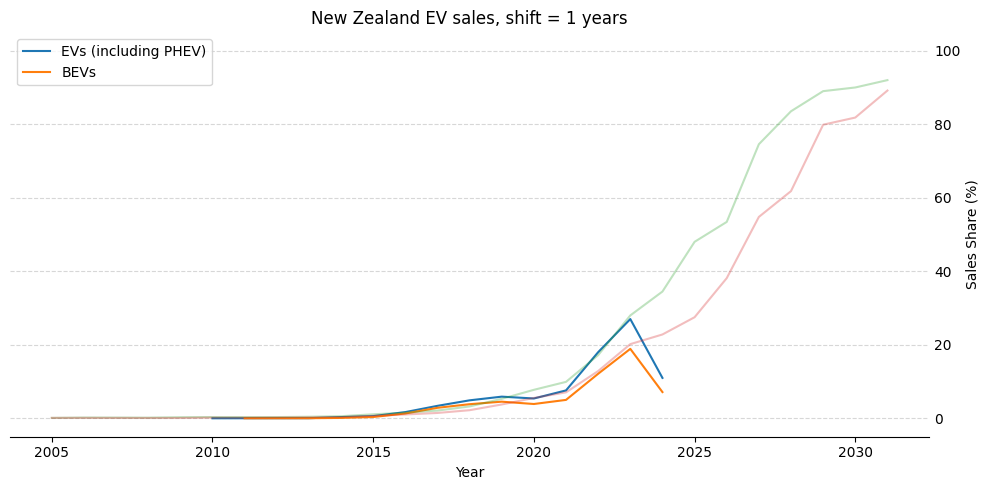

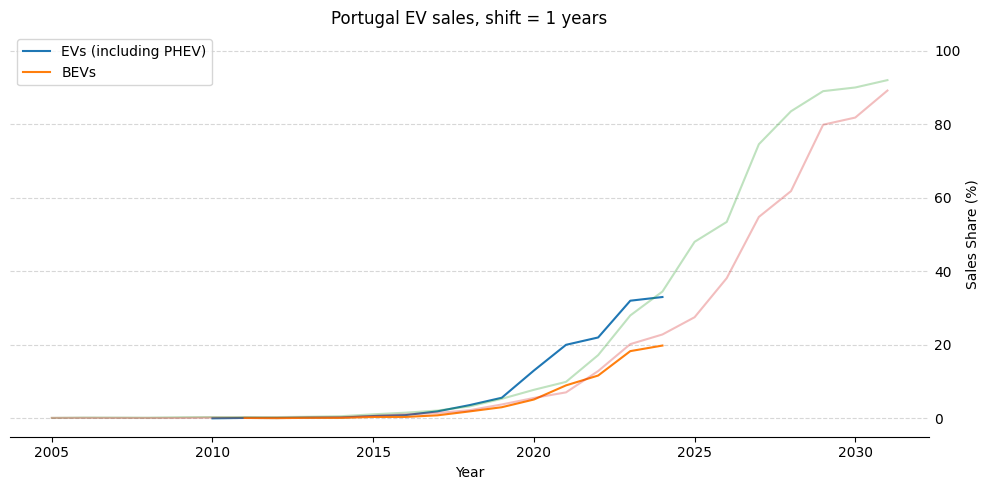

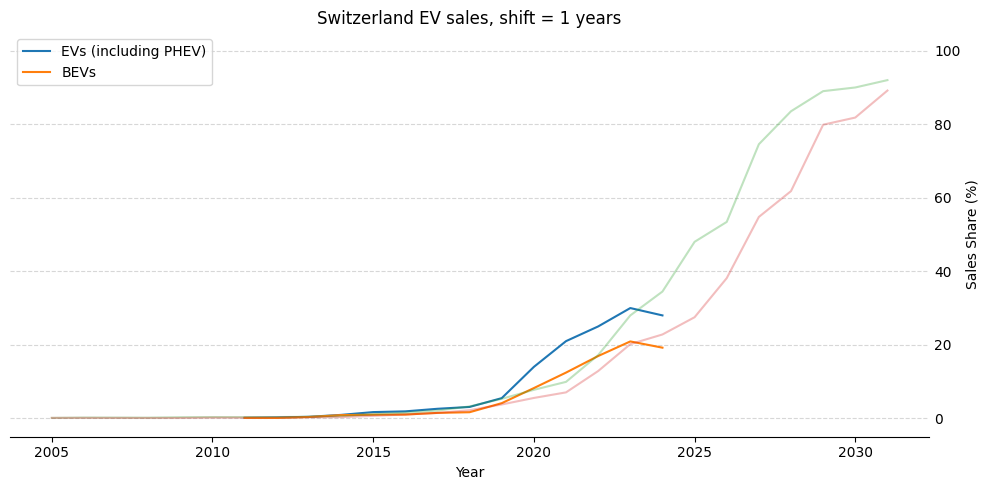

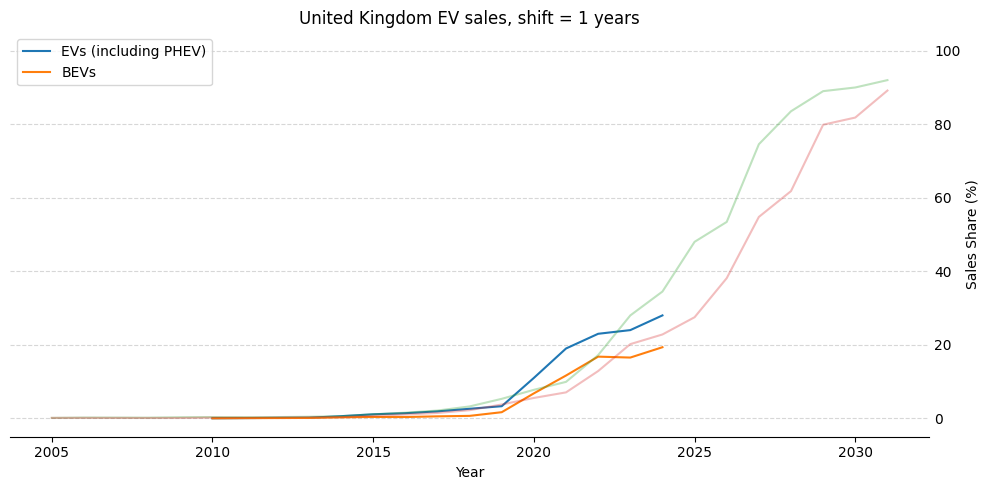

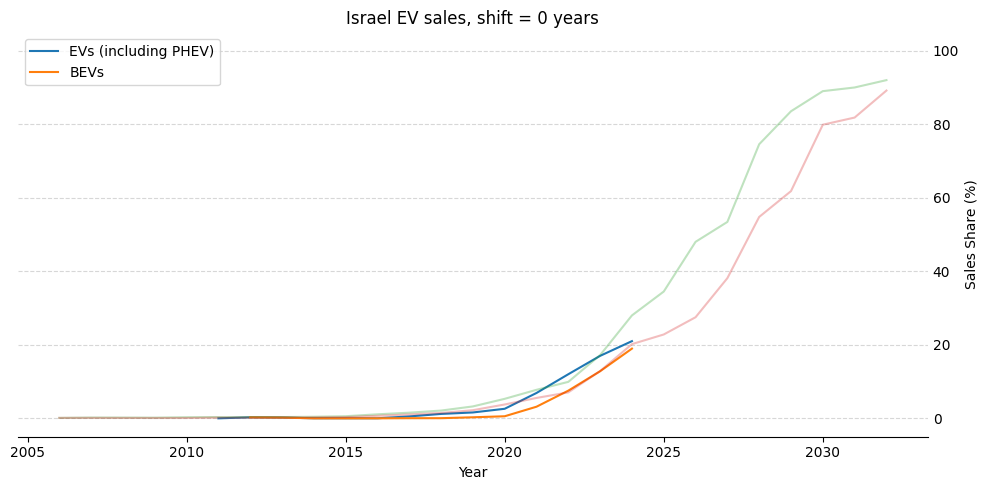

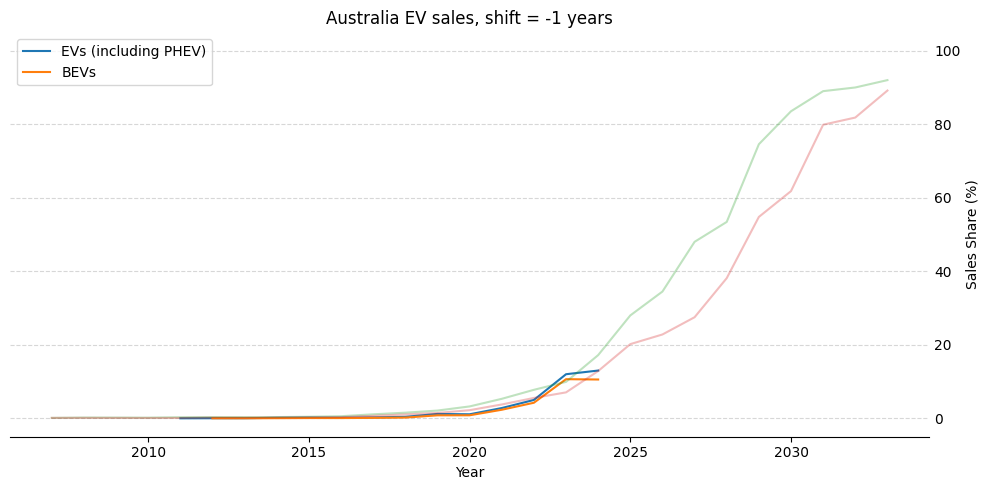

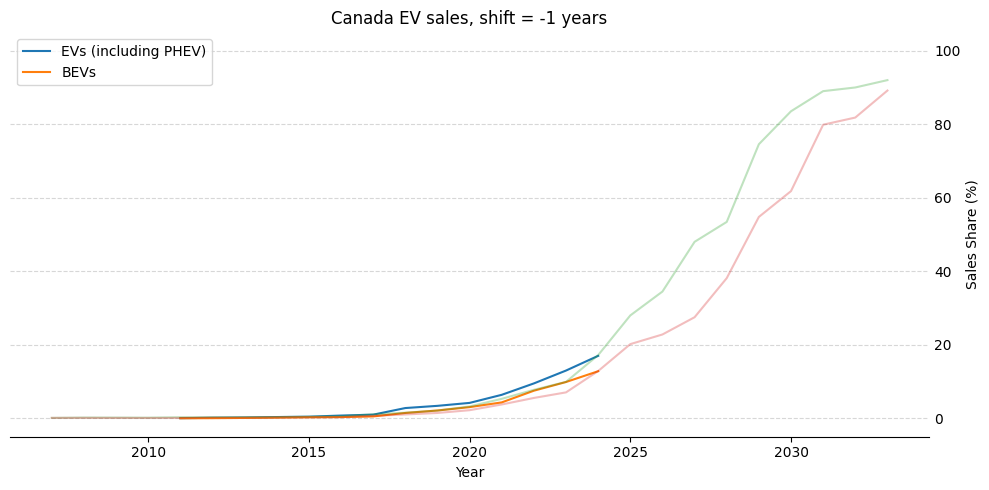

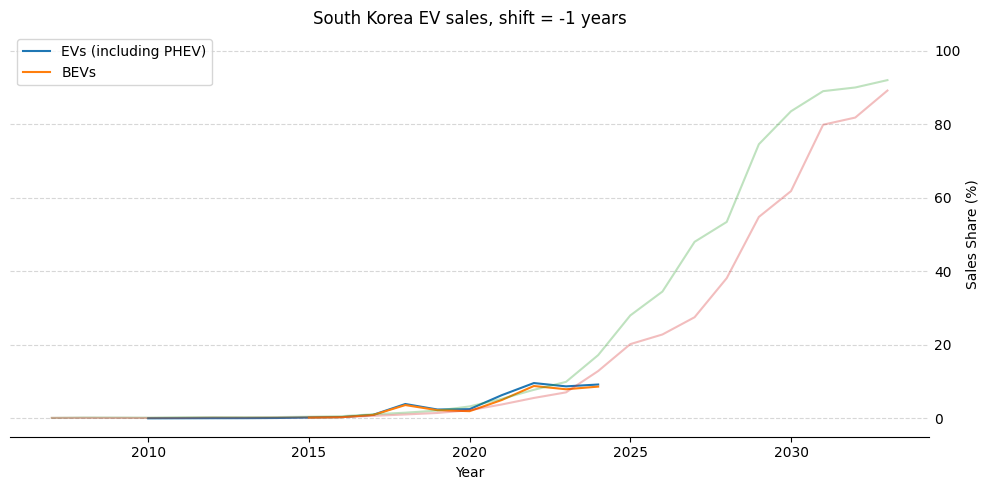

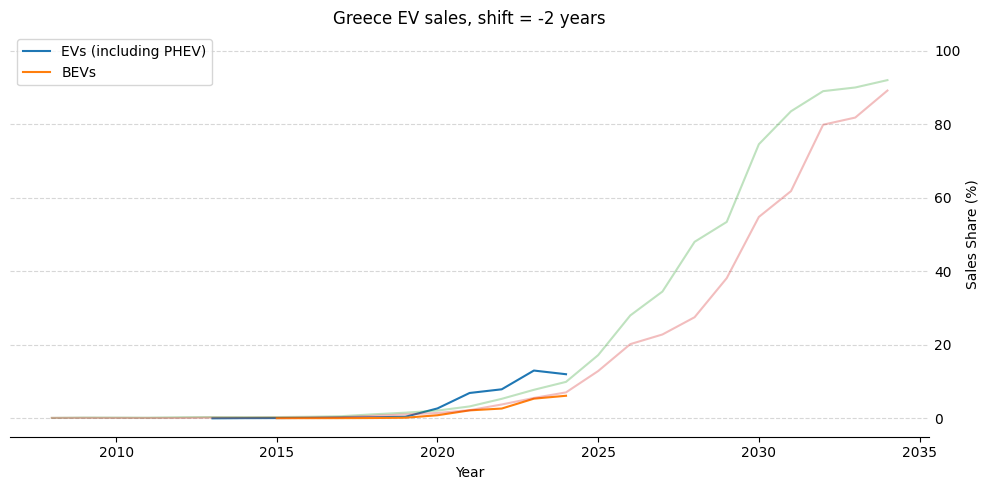

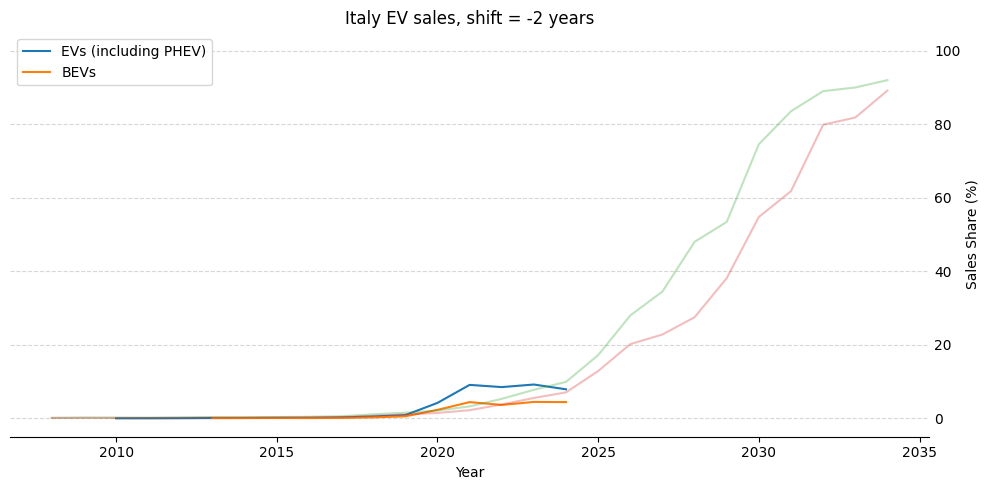

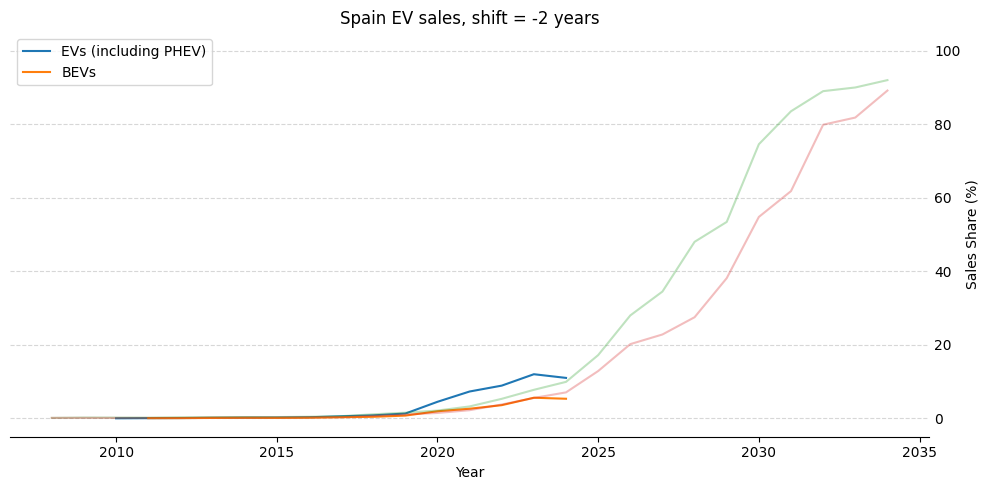

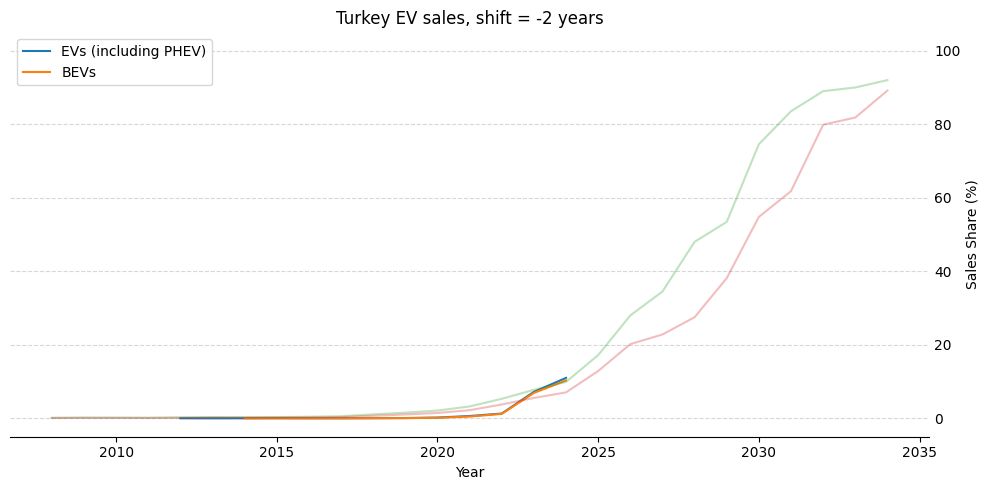

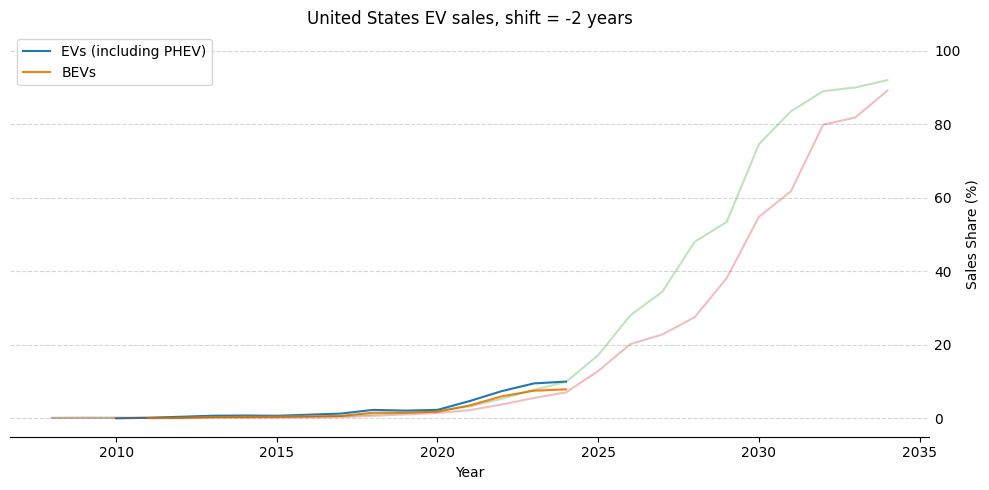

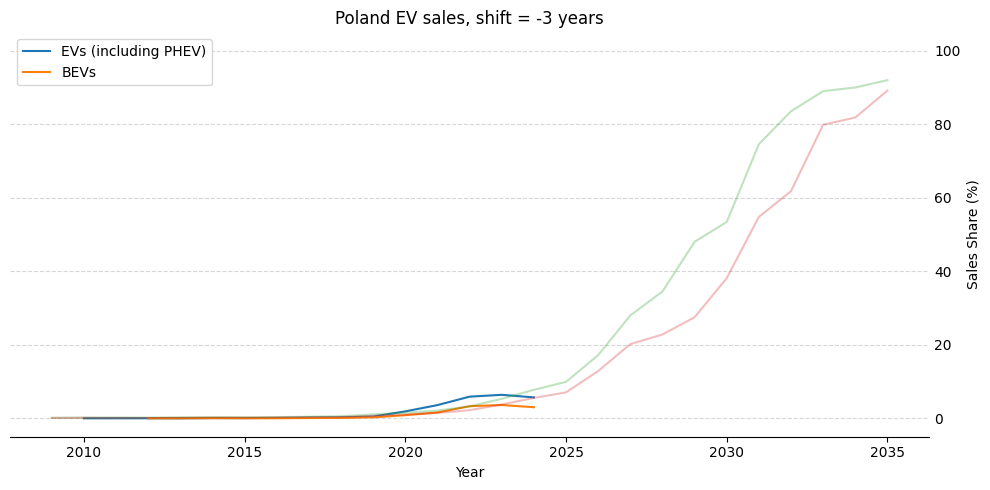

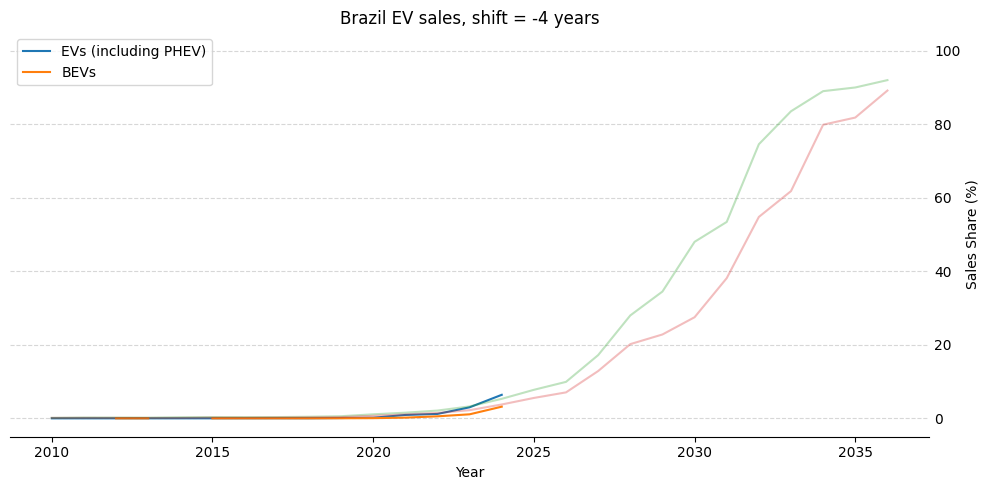

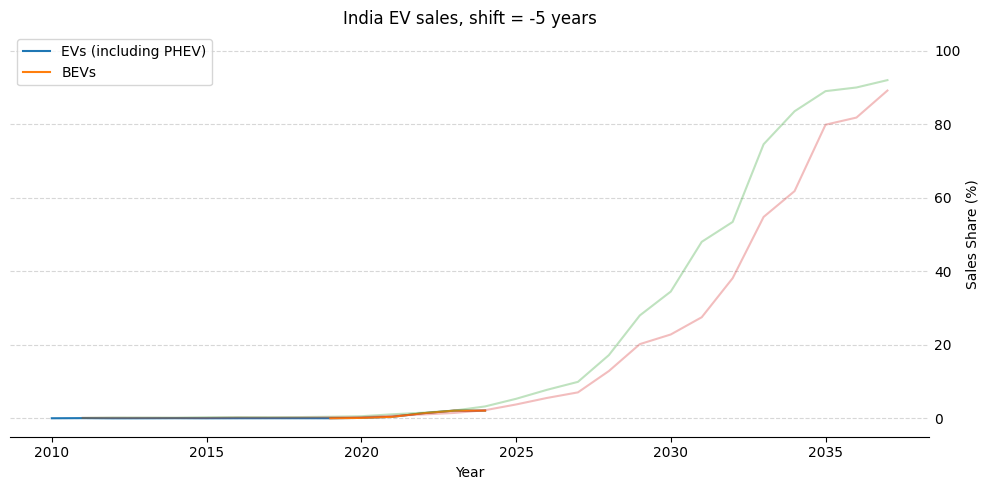

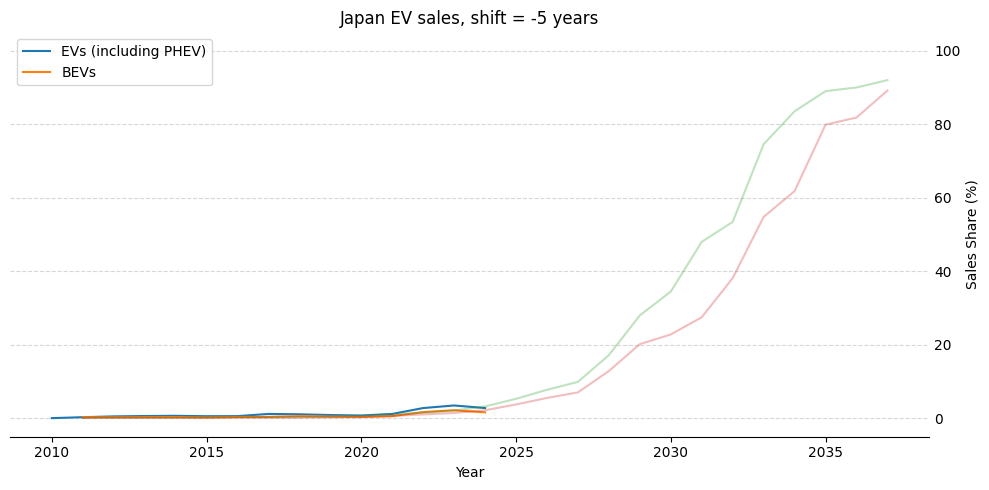

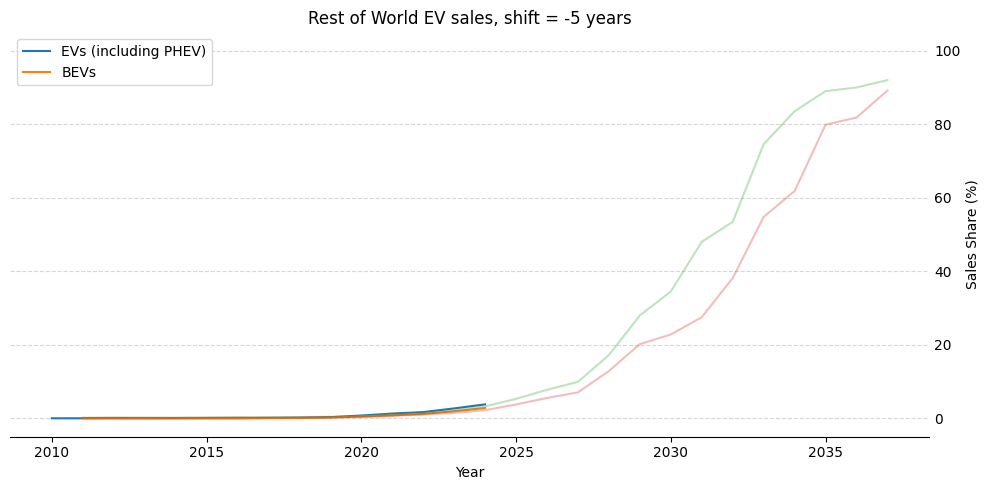

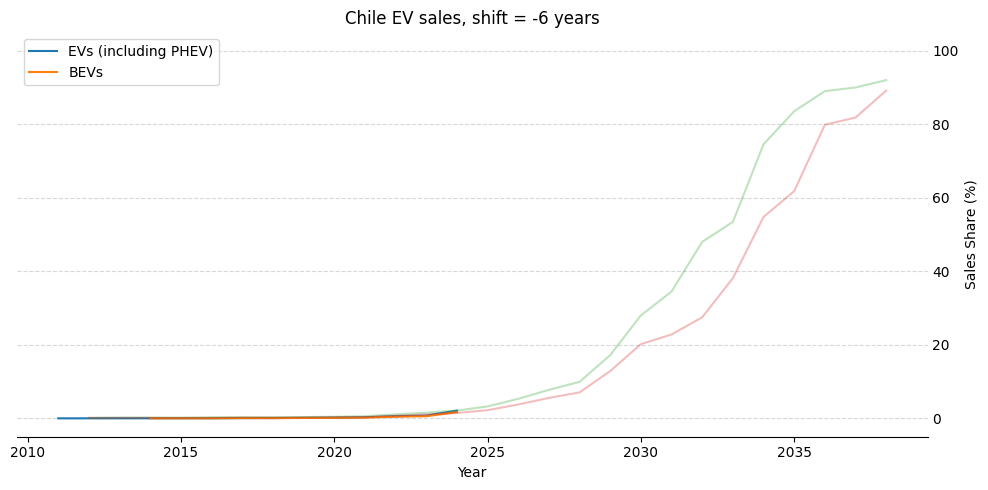

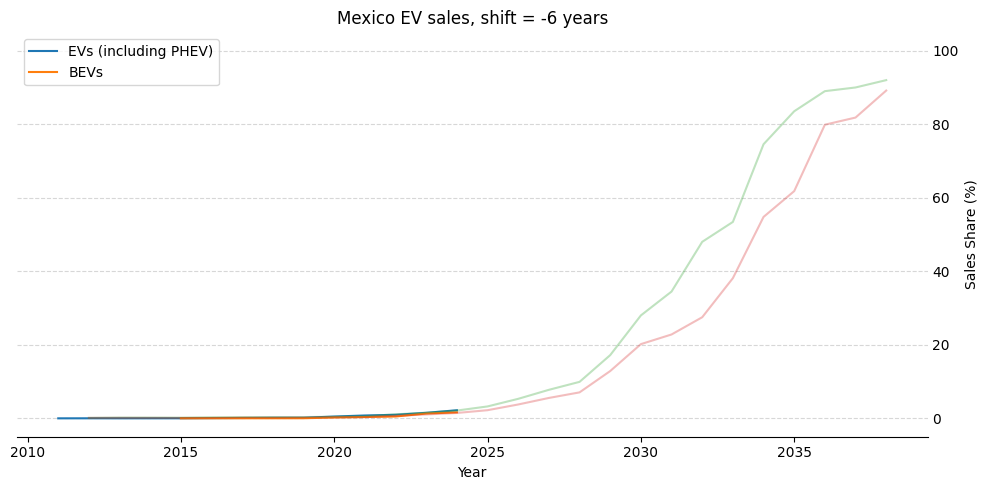

In [9]:

relevant_sales = e_car_sales[only_countries]

# How many years each country is ahead / behind
countries_offsets = {c: 0 for c in relevant_sales.index.get_level_values(0).unique()}

for i in range(10):
    
    countries = relevant_sales.index.get_level_values(0).unique()
    years = relevant_sales.index.get_level_values(1).unique()
    min_year, max_year = int(years.min()), int(years.max())
    min_off = min(int(min(countries_offsets.values())), 0)
    max_off = max(int(max(countries_offsets.values())), 0)
    start_year = min_year + min_off
    end_year = max_year + max_off + 1
    expanded_years = range(start_year, end_year)

    expanded_index = pd.MultiIndex.from_product([countries, expanded_years], names=relevant_sales.index.names)
    
    # shift the sales data in every country by the years in country_offsets
    shifted_sales = (
        relevant_sales.reindex(expanded_index)
        .groupby(level=0, group_keys=False)
        .apply(lambda g: g.sort_index(level=1).shift(countries_offsets.get(g.index.get_level_values(0)[0], 0)))
    )

    # includes PHEV
    mean_ev_sales_share = (
            (shifted_sales['ev_sales_share'] * shifted_sales['total_cars_sold'])
            .groupby(level=1).sum()
            /
            shifted_sales['total_cars_sold'].groupby(level=1).sum()
    ).sort_index().to_frame(name='EV')

    mean_bev_sales_share = (
            (shifted_sales['bev_share_car_sales'] * shifted_sales['total_cars_sold'])
            .groupby(level=1).sum()
            /
            shifted_sales['total_cars_sold'].groupby(level=1).sum()
    ).sort_index().to_frame(name='BEV')

    #ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(figsize=(8, 4), legend=True)
    #ax.set_xlabel('Year')
    #plt.tight_layout()
    #plt.show()

    #ax = shifted_sales['ev_sales_share'].unstack(level=0).plot(ax = ax, figsize=(10, 5), legend=False, alpha=0.3)
    #ax.set_xlabel('Year')
    #ax.set_ylabel('EV Sales Share')
    #ax.set_ylim(0, 100)
    #plt.tight_layout()
    #plt.show()
    
    
    
    #norway = shifted_sales['ev_sales_share'].loc['Norway'].sort_index()
    #mean_series = mean_ev_sales_share['EV (incl. PHEV)'].sort_index()
    #aligned = pd.concat([norway.rename('norway'), mean_series.rename('mean')], axis=1, join='inner').dropna()
    #a = aligned['norway'].to_numpy()
    #v = aligned['mean'].to_numpy()
    #convolved = np.convolve(a, v, mode='same')
    #convoluted = pd.Series(convolved, index=aligned.index, name='Convolution')

    a_ev = mean_ev_sales_share['EV'].to_numpy()
    a_bev = mean_bev_sales_share['BEV'].to_numpy()
    for c in countries_offsets:
        v_ev = relevant_sales['ev_sales_share'].loc[c].to_numpy()
        v_bev = relevant_sales['bev_share_car_sales'].loc[c].to_numpy()
        
        assert len(v_ev) == len(v_bev)
        c_start_year = int(relevant_sales['bev_share_car_sales'].loc[c].index.min())
        
        base_offset = start_year - c_start_year - 1
        
        # offsets should be the same
        offsets, correlated_ev = correlate_slice_normalized(a_ev, v_ev)
        _, correlated_bev = correlate_slice_normalized(a_bev, v_bev)
        
        # consider correlation of both EV (includes PHEV) and BEV fractions 
        correlated = (correlated_ev + correlated_bev) / 2
        
        new_shift = offsets[np.argmax(correlated)] + base_offset
        countries_offsets[c] = new_shift
        
        # Debug info for specific countries
        if c in []:
            print(c_start_year, start_year, end_year, base_offset, new_shift)
            ax = pd.concat([e_car_sales.loc[c]['ev_sales_share'], e_car_sales.loc[c]['bev_share_car_sales']], axis=1).plot(figsize=(8, 4), legend=False)
            ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(ax=ax, figsize=(8, 4), legend=True, alpha=0.3)
            ax.set_title('EV Sales Share')
            ax.set_xlabel('Year')
            ax.set_ylabel('EV Sales Share')
            plt.tight_layout()
            plt.show()
        
            corr_series = pd.concat([
                pd.Series(correlated, name='Correlation'),
                pd.Series(correlated_ev, name='EV'),
                pd.Series(correlated_bev, name='BEV')
                ], axis=1)
            ax = corr_series.plot(figsize=(8, 2))
            ax.set_title(f'Correlation of {c}')
            plt.tight_layout()
            plt.show()
            
            print(np.argmax(correlated), new_shift, offsets[np.argmax(correlated_ev)] + base_offset, offsets[np.argmax(correlated_bev)] + base_offset)
            
            ax = df_shift_index(pd.concat([e_car_sales.loc[c]['ev_sales_share'], e_car_sales.loc[c]['bev_share_car_sales']], axis=1), new_shift).plot(figsize=(8, 4), legend=False)
            ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(ax=ax, figsize=(8, 4), legend=True, alpha=0.3)
            ax.set_title(f'{c}, Shift = {new_shift}')
            ax.set_xlabel('Year')
            ax.set_ylabel('EV Sales Share')
            plt.tight_layout()
            plt.show()


print('Time shift of all the countries (how many years they are ahead / behind the average transition)')
display({k: int(v) for k, v in countries_offsets.items()})



ax = shifted_sales['ev_sales_share'].unstack(level=0).plot(figsize=(10, 5), legend=False, alpha=0.3, color='grey', lw=1)
ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).rename(columns={'EV': 'EVs (including PHEV)', 'BEV': 'BEVs'}).plot(ax = ax, figsize=(10, 5), legend=True)
ax.set_title(f'All countries time-shifted EV sales share vs average trajectory')
ax.set_xlabel('Year (only for average, others are time-shifted)')
ax.set_ylabel('Sales Share (%)')
ax.set_ylim(-5, 105)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='y', which='major', length=0)
plt.grid(linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.savefig(f'figures/world/ev_trajectories/all_ev_trajectories.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/world/ev_trajectories/all_ev_trajectories.svg', dpi=300, bbox_inches='tight')
plt.show()


for c in sorted(countries_offsets.keys(), key=lambda x: countries_offsets[x], reverse=True):
    ax = relevant_sales.loc[c]['ev_sales_share'].plot(figsize=(10, 5), legend=True, label='EVs (including PHEV)')
    ax = relevant_sales.loc[c]['bev_share_car_sales'].plot(ax = ax, figsize=(10, 5), legend=True, label='BEVs')
    ax = df_shift_index(pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1), -countries_offsets[c]).plot(ax = ax, figsize=(10, 5), alpha=0.3, legend=False)
    ax.set_title(f'{c} EV sales, shift = {countries_offsets[c]} years')
    ax.set_xlabel('Year')
    ax.set_ylabel('Sales Share (%)')
    ax.set_ylim(-5, 105)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    plt.tick_params(axis='y', which='major', length=0)
    plt.grid(linestyle='--', alpha=0.5, axis='y')
    plt.tight_layout()
    plt.savefig(f'figures/world/ev_trajectories/ev_trajectory_{c}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/world/ev_trajectories/ev_trajectory_{c}.svg', dpi=300, bbox_inches='tight')
    plt.show()

TODO: In the future, an S-Curve can be fit to this trajectory and parameters can be extracted to understand the speed of the transition